This model imagines a simple 10x10 grid. 
- Each grid cell, i, can have a specific nutrient treatment. 
- Each zone (i.e., linked neighbouring grid cells) can have a specific water treatment.

Restrictions are present:
- Total amount of water available, *W_total*
- Total amount of nutrient available, *N_total*

TO DO:
- fix yield
- more subdivisions of nutrients (N, P, etc.)
- more grid cells
- time dependent with soil data, theory -> water, nutrient

### Define all parameters

In [15]:
#from pyqubo import Binary
import numpy as np
from itertools import product
from collections.abc import Iterable

from dwave.system import LeapHybridDQMSampler
import neal
import dimod
#from boltz import QUBO, get_yield

import pandas as pd
import pickle
import random

from importlib import reload
import os
import sys
sys.path.insert(0, os.path.abspath('./'))
import boltz
reload(boltz)
from boltz import QUBO, get_yield, convert_slacks_to_binary

from itertools import combinations_with_replacement


### Define QUBO and yield dependence on water and nutrients

Yield is defined as a quadratic function for now, with a known response to water and nutrients.

In [6]:
def get_slacks(ngridcells, xx, xx_total, delta_xx=3):
    # ngridcells: number of cells
    # xx : possible values in each ngridcells
    # xx_total : maximum sum of xx in all cells
    # delta_xx : assumes xx values are sampled every delta_xx units ; i.e., resolution
    #      delta_xx = np.abs(xx[0] - xx[1]) , assuming xx values are ordered
    values = []
    if ngridcells < 100:
        for i in combinations_with_replacement(xx,ngridcells):
            values.append(np.array(i).sum())
    else:
        values = np.arange(ngridcells*np.min(xx),ngridcells*np.max(xx)+1, delta_xx)
    values = np.unique(values)
# From these, determine all values of slack variable
    ind = np.where(((xx_total- values) >= 0) & (values <= xx_total))#, Wtotal-np.unique(wvalues))
    slacks = values[ind].max() - values[ind]
    return slacks

In [7]:
def convert_to_prescription_map(qubomodel, sampleset, constraints):
    slacks_dict = {}
    binaryval = False
    for k,v in constraints.items():
        constraint = '{}_{}_{}'.format(v['lhs'],v['kind'],v['rhs'])
        if 'many_to_one' in v['kind']:
            slacks_dict[constraint] = v['slacks']
        else:
            slacks_dict[constraint] = qubomodel.constraint[constraint]['slack_variables']
            if len(slacks_dict[constraint])==1:
                binaryval = True
    
    sample = sampleset.first.sample
    newdict = {}
    total = {}
    for key,value in sample.items():
        print (key ,value)
        try:
            newdict[int(key)] = {}
            for k,v in qubomodel.secondary.items():
                if k in total.keys():
                    total[k] += v[int(value)]
                else:
                    total[k] = v[int(value)]
                newdict[int(key)][k] = v[int(value)]
        except:
            constraint, _ = key.split('_S')
            if binaryval:
                addvalue = value * slacks_dict[constraint][0]
            else:
                addvalue = slacks_dict[constraint][int(value)]
            if constraint in newdict:
                newdict[constraint] += addvalue
            elif constraint in slacks_dict:
                newdict[constraint] = addvalue

    return newdict, total
#newdict, total


Visualize get_yield function

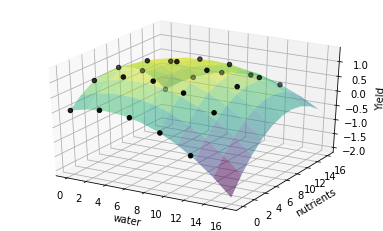

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

#xx,yy = working.secondary['water'], working.secondary['nutrients']
xx = np.outer(np.linspace(0,16,10),np.ones(10))
yy = np.outer(np.linspace(0,16,10),np.ones(10)).T
zz = get_yield(xx,yy)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(xx,yy,zz,cmap='viridis',alpha=0.5)
xx = np.outer(np.linspace(0,12,5),np.ones(5))
yy = np.outer(np.linspace(0,16,5),np.ones(5)).T
zz = get_yield(xx,yy)
ax.set_zlabel('Yield')
ax.set_xlabel('water')
ax.set_ylabel('nutrients')
ax.scatter(xx,yy,zz,color='k')
fig.subplots_adjust(right=0.98)

In [5]:
dfsummary2 = pd.DataFrame(columns=['ngridcells',
                                  'Wconstraint','Wconstraint_percent_of_optimal',
                                  'Nconstraint','Nconstraint_percent_of_optimal',
                                  'Water_used','Nutrients_used',
                                 'qpu_access_time','charge_time','run_time','energy','filename'])
dfsummary2 = pd.read_csv('DWAVE_summary_5DEC2020.csv',index_col=0)
#dfsummary

dfsolutions = pd.DataFrame()


# Start here

In [82]:
dqm_slack = False
run_model = True
n_repeats = 5

# fraction of optimal water/nutrients available
wr_f, nr_f = 4./6., 6./8.

# possible values of water, as integers
water = np.array([3,6,9]) # min is 12 # max is Wtotal
water = np.array([0,2,4,6]) # min is 12 # max is Wtotal

w_peak = 6 # optimal yield obtained when w = w_peak, n = n_peak

# possible values of nutrients, as integers
nutrients = np.array([4,8,12]) # min is 16 # max is Ntotal
nutrients = np.array([0,2,4,6,8]) # min is 16 # max is Ntotal

n_peak = 8 # optimal yield obtained when n = n_peak, w = w_peak

# number of farms
#nfarms = [4] #,16,36,100]
#nfarms = [500]
nfarms = [4]#, 
nfarms = [16, 36]

nfarms = [4,16,36,100]#,1000,1e4]#,1e5,1e6]
nfarms = [100]
water_dict = {4:2, 16:5, 36:10, 100:15, 1000:100, 1e4:500, 1e5:1000, 1e6:2000}
wr_f, nr_f = 4./6., 6./8.
wr_f, nr_f = 1.0, 1.0

#nfarms = [4,16,36,100]
for ngridcells in nfarms:
    Nnutrientzones = int(ngridcells)
    Nwaterzones = water_dict[Nnutrientzones]
    ii = 0
    zone_restrictions = {}
    random.seed(0)
    for i,j in enumerate(np.sort(random.sample(range(Nnutrientzones), Nwaterzones-1))):
        zone_restrictions[i] = np.arange(ii,j)
        ii = j
    zone_restrictions[i+1] = np.arange(ii, Nnutrientzones)
#    zone_restrictions = {'a':[0,1],
#                         'b':[2,3], 
#                         'c':[4,5,6,7,8],
#                         'd':[9,10,11,15],
#                         'e':[12,13,14],
#                         'f':range(16,1001,1)}
    
# yield efficiency for each grid cell,
#     - could be based on previous years' average yield maps
    np.random.seed(0)
    weights = np.random.uniform(0,1,ngridcells)

    gridcells = np.arange(ngridcells)

    llambda = get_yield(w_peak, n_peak)*weights.max()*10.

    # available water and nutrients
    # This is set to a certain percentage of optimal values

    Wtotal = np.ceil(w_peak*ngridcells * wr_f)
    Ntotal = np.ceil(n_peak*ngridcells * nr_f)

    # these are possible values of slack variables
    water_slacks = get_slacks(ngridcells, water, Wtotal, delta_xx = 2)
    nutrient_slacks = get_slacks(ngridcells, nutrients, Ntotal, delta_xx = 2)
    
    if not dqm_slack:
        water_slacks = convert_slacks_to_binary(water_slacks, delta_s = 2)
        nutrient_slacks = convert_slacks_to_binary(nutrient_slacks, delta_s = 2)
        
    constraints = {
        'water1':{
            'lhs':'water',
            'rhs':Wtotal,
            'kind':'less_equal',
            'll': llambda,
            'slacks':water_slacks #3*np.array([1,2,4]) #allowed values of slack: [0,3,6,9,12,15]
            #  extra 18,21 not allowed
            #     so: 0 1 1 and 1 1 1 should be penalized 
        },
        'nutrients1':{
            'lhs':'nutrients',
            'rhs':Ntotal,
            'kind':'less_equal',
            'll':llambda,
            'slacks':nutrient_slacks #4*np.array([1,2,4]) #allowed values of slack: [0,4,8,12,16,20] 
            #   extra 24,28 not allowed
            #      so: 0 1 1 and 1 1 1 should be penalized
        },
    
        'water2':{
            'lhs':'water',
            'rhs':zone_restrictions,
            'kind':'many_to_one',
            'll':llambda,
            'slacks':None
        }
    
    }
    
    filename = './savedfiles/qubo{}_{}_{}_lambda{}_{}constraints_{}prescriptions'.format(
        ngridcells,
        wr_f,nr_f,
        llambda,
        len(constraints),
        len(water)*len(nutrients))

    primary_variable = {'gridcells':gridcells}
    secondary_variables = {'water':water, 'nutrients':nutrients}
    qubomodel = QUBO(primary_variable, secondary_variables,
               weight=weights,func=get_yield)

    for _, constraint in constraints.items():
        qubomodel.add_constraint(constraint['lhs'],
                             constraint['rhs'],
                             slack_variables = constraint['slacks'],
                             kind=constraint['kind'],
                             ll=constraint['ll'],
                            normalize=True,
                            dqm_slack = dqm_slack)
        
    qubomodel.build_dqm()
    df = qubomodel.summarize()
    df['filename'] = '{}_all.pickle'.format(filename)
    df['Wconstraint'] = Wtotal
    df['Wconstraint_percent_optimal'] = wr_f*100.
    df["Nconstraint"] = Ntotal
    df['Nconstraint_percent_optimal'] = nr_f*100.
    #display(df)
    if run_model:
        addsamples = []
        for ii in range(n_repeats):
            qubomodel.solve_dqm()
    #qubomodel.sampleset
            addsamples.append(qubomodel.sampleset)
            pickle.dump(qubomodel.sampleset, open('{}_{}.pickle'.format(filename,ii),'wb'))
        samplesets = dimod.concatenate(addsamples)
        pickle.dump(samplesets, open('{}_all.pickle'.format(filename), 'wb'))
        df['first_energy'] = samplesets.first.energy
    # record timing
        for key,value in qubomodel.sampleset.info.items(): #qpu_access_time
            df[key] = value
        df['llambda'] = llambda
        
        solution,totals = convert_to_prescription_map(qubomodel, samplesets, constraints)
        df['solution'] = [solution]
        df['Wused'] = totals['water']
        df['Nused'] = totals['nutrients']
        df['dqm_slack'] = dqm_slack
        df['n_repeats'] = n_repeats
    #break
        dfsolutions = dfsolutions.append(df, ignore_index=True)

water. Adding 9 independent slack variables
2018
nutrients. Adding 9 independent slack variables
2036
water. Adding 0 independent slack variables
0 19
1 19
2 19
3 19
4 19
5 19
6 19
7 19
8 19
9 19
10 19
11 19
12 19
13 19
14 19
15 19
16 18
17 19
18 19
19 19
20 19
21 19
22 19
23 19
24 19
25 19
26 19
27 19
28 19
29 19
30 19
31 19
32 19
33 19
34 3
35 19
36 19
37 19
38 19
39 19
40 19
41 19
42 19
43 19
44 19
45 19
46 19
47 19
48 19
49 19
50 19
51 19
52 19
53 19
54 19
55 19
56 19
57 19
58 19
59 19
60 19
61 19
62 19
63 19
64 19
65 19
66 19
67 18
68 19
69 18
70 19
71 19
72 19
73 19
74 19
75 18
76 19
77 18
78 19
79 19
80 19
81 19
82 17
83 19
84 19
85 19
86 19
87 18
88 19
89 19
90 19
91 19
92 18
93 19
94 18
95 19
96 19
97 19
98 19
99 2
water_less_equal_600.0_S2 0
water_less_equal_600.0_S4 1
water_less_equal_600.0_S8 1
water_less_equal_600.0_S16 0
water_less_equal_600.0_S32 0
water_less_equal_600.0_S64 0
water_less_equal_600.0_S128 0
water_less_equal_600.0_S256 0
water_less_equal_600.0_S90.0 0
nutr

In [20]:
dfsolutions.tail(4)

,n_cells,n_prescriptions,n_constraints,n_slacks,n_dqm_cases,n_dqm_variables,n_dqm_case_interactions,n_dqm_variable_interactions,filename,Wconstraint,...,charge_time,run_time,llambda,solution,Wused,Nused,dqm_slack,n_repeats,Yield,Optimal Yield
31,4,20,3,8,96,12,3728,50,./savedfiles/qubo4_0.6666666666666666_0.75_lam...,16.0,...,4997801,4997801,8.888665,"{0: {'water': 4, 'nutrients': 8}, 1: {'water':...",14,26,False,1.0,NaN,NaN
32,16,20,3,12,344,28,55800,342,./savedfiles/qubo16_0.6666666666666666_0.75_la...,64.0,...,5000000,5002831,11.976794,"{0: {'water': 6, 'nutrients': 6}, 1: {'water':...",68,98,False,1.0,NaN,NaN
33,36,20,3,14,748,50,272328,1176,./savedfiles/qubo36_0.6666666666666666_0.75_la...,144.0,...,5000000,5013314,12.162668,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",152,238,False,1.0,NaN,NaN
34,100,20,3,17,2034,117,2048256,6714,./savedfiles/qubo100_0.6666666666666666_0.75_l...,400.0,...,7138050,7138050,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",454,688,False,1.0,NaN,NaN


In [83]:
dfsolutions#qubomodel.slack_labels

,n_cells,n_prescriptions,n_constraints,n_slacks,n_dqm_cases,n_dqm_variables,n_dqm_case_interactions,n_dqm_variable_interactions,filename,Wconstraint,...,charge_time,run_time,llambda,solution,Wused,Nused,dqm_slack,n_repeats,Yield,Optimal Yield
0,4,9,3,4,40,6,630,14,./savedfiles/qubo4_0.6_0.6_lambda8.88866512529...,15.0,...,4997323,4997323,8.888665,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",12,20,True,NaN,2.397096,2.997296
1,16,9,3,8,152,18,10872,152,./savedfiles/qubo16_0.6_0.6_lambda11.976793803...,58.0,...,4996001,4996001,11.976794,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",57,80,True,NaN,9.345502,11.347247
2,36,9,3,16,340,38,56214,702,./savedfiles/qubo36_0.6_0.6_lambda12.162667873...,130.0,...,5000000,5015768,12.162668,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",135,188,True,NaN,20.998872,25.022621
3,100,9,3,42,942,102,438750,5150,./savedfiles/qubo100_0.6_0.6_lambda12.28391315...,360.0,...,5344522,5361223,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",348,568,True,NaN,51.085207,58.760747
4,4,9,3,2,40,6,630,14,./savedfiles/qubo4_0.6_0.6_lambda8.88866512529...,15.0,...,5000000,5013858,8.888665,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",12,20,False,NaN,2.397096,2.997296
5,16,9,3,4,152,20,10872,184,./savedfiles/qubo16_0.6_0.6_lambda11.976793803...,58.0,...,4995715,4995715,11.976794,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",57,80,False,NaN,9.347905,11.347247
6,36,9,3,6,336,42,54918,846,./savedfiles/qubo36_0.6_0.6_lambda12.162667873...,130.0,...,5000000,5002904,12.162668,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",132,180,False,NaN,20.829112,25.022621
7,100,9,3,10,920,110,418950,5950,./savedfiles/qubo100_0.6_0.6_lambda12.28391315...,360.0,...,5372045,5396829,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",321,516,False,NaN,49.180104,58.760747
8,500,9,3,14,4528,514,10230750,131750,./savedfiles/qubo500_0.6_0.6_lambda12.41407796...,1800.0,...,83768077,83768077,12.414078,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",1548,3008,False,NaN,267.766048,308.595901
9,1000,9,3,16,9032,1016,40747500,515500,./savedfiles/qubo1000_0.6_0.6_lambda12.4260287...,3600.0,...,236367325,237586462,12.426029,"{0: {'water': 3, 'nutrients': 8}, 1: {'water':...",5967,6932,False,NaN,605.625981,616.351508


In [22]:
def convert_solution_to_yield(solution):
    yields = [get_yield(value['water'], value['nutrients']) for key,value in solution.items() if isinstance(key, int)]
    np.random.seed(0)
    weights = np.random.uniform(0,1,len(yields))
    #print(yields, weights)
    return np.sum(np.array(yields)*weights)

In [23]:
convert_solution_to_yield(eval(dfsolutions.solution[0]))

2.3970957267194075

In [84]:
dfsolutions['Yield'] = dfsolutions.apply(lambda row: convert_solution_to_yield(eval(row.solution)) if isinstance(row.solution,str)
                  else convert_solution_to_yield(row.solution), axis=1)
for i, row in dfsolutions.iterrows():
    np.random.seed(0)
    weights = np.random.uniform(0,1,row.n_cells)
    dfsolutions.loc[i, 'Optimal Yield'] = np.sum( get_yield(6,8) * weights)

In [25]:
dfsolutions

,n_cells,n_prescriptions,n_constraints,n_slacks,n_dqm_cases,n_dqm_variables,n_dqm_case_interactions,n_dqm_variable_interactions,filename,Wconstraint,...,charge_time,run_time,llambda,solution,Wused,Nused,dqm_slack,n_repeats,Yield,Optimal Yield
0,4,9,3,4,40,6,630,14,./savedfiles/qubo4_0.6_0.6_lambda8.88866512529...,15.0,...,4997323,4997323,8.888665,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",12,20,True,NaN,2.397096,2.997296
1,16,9,3,8,152,18,10872,152,./savedfiles/qubo16_0.6_0.6_lambda11.976793803...,58.0,...,4996001,4996001,11.976794,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",57,80,True,NaN,9.345502,11.347247
2,36,9,3,16,340,38,56214,702,./savedfiles/qubo36_0.6_0.6_lambda12.162667873...,130.0,...,5000000,5015768,12.162668,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",135,188,True,NaN,20.998872,25.022621
3,100,9,3,42,942,102,438750,5150,./savedfiles/qubo100_0.6_0.6_lambda12.28391315...,360.0,...,5344522,5361223,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",348,568,True,NaN,51.085207,58.760747
4,4,9,3,2,40,6,630,14,./savedfiles/qubo4_0.6_0.6_lambda8.88866512529...,15.0,...,5000000,5013858,8.888665,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",12,20,False,NaN,2.397096,2.997296
5,16,9,3,4,152,20,10872,184,./savedfiles/qubo16_0.6_0.6_lambda11.976793803...,58.0,...,4995715,4995715,11.976794,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",57,80,False,NaN,9.347905,11.347247
6,36,9,3,6,336,42,54918,846,./savedfiles/qubo36_0.6_0.6_lambda12.162667873...,130.0,...,5000000,5002904,12.162668,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",132,180,False,NaN,20.829112,25.022621
7,100,9,3,10,920,110,418950,5950,./savedfiles/qubo100_0.6_0.6_lambda12.28391315...,360.0,...,5372045,5396829,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",321,516,False,NaN,49.180104,58.760747
8,500,9,3,14,4528,514,10230750,131750,./savedfiles/qubo500_0.6_0.6_lambda12.41407796...,1800.0,...,83768077,83768077,12.414078,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",1548,3008,False,NaN,267.766048,308.595901
9,1000,9,3,16,9032,1016,40747500,515500,./savedfiles/qubo1000_0.6_0.6_lambda12.4260287...,3600.0,...,236367325,237586462,12.426029,"{0: {'water': 3, 'nutrients': 8}, 1: {'water':...",5967,6932,False,NaN,605.625981,616.351508


In [167]:
weights
#np.sum( get_yield(4,6) * weights)

array([0.5488135 , 0.71518937, 0.60276338, 0.54488318])

TO DO:
- calculate total yield for each solution based on water and nutrient and weights for each gridcell

In [87]:
dfsolutions.to_csv('dec8_2020_corrected.csv', index=False)

In [81]:
dfsolutions

,n_cells,n_prescriptions,n_constraints,n_slacks,n_dqm_cases,n_dqm_variables,n_dqm_case_interactions,n_dqm_variable_interactions,filename,Wconstraint,...,charge_time,run_time,llambda,solution,Wused,Nused,dqm_slack,n_repeats,Yield,Optimal Yield
0,4,9,3,4,40,6,630,14,./savedfiles/qubo4_0.6_0.6_lambda8.88866512529...,15.0,...,4997323,4997323,8.888665,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",12,20,True,NaN,2.397096,2.997296
1,16,9,3,8,152,18,10872,152,./savedfiles/qubo16_0.6_0.6_lambda11.976793803...,58.0,...,4996001,4996001,11.976794,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",57,80,True,NaN,9.345502,11.347247
2,36,9,3,16,340,38,56214,702,./savedfiles/qubo36_0.6_0.6_lambda12.162667873...,130.0,...,5000000,5015768,12.162668,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",135,188,True,NaN,20.998872,25.022621
3,100,9,3,42,942,102,438750,5150,./savedfiles/qubo100_0.6_0.6_lambda12.28391315...,360.0,...,5344522,5361223,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",348,568,True,NaN,51.085207,58.760747
4,4,9,3,2,40,6,630,14,./savedfiles/qubo4_0.6_0.6_lambda8.88866512529...,15.0,...,5000000,5013858,8.888665,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",12,20,False,NaN,2.397096,2.997296
5,16,9,3,4,152,20,10872,184,./savedfiles/qubo16_0.6_0.6_lambda11.976793803...,58.0,...,4995715,4995715,11.976794,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",57,80,False,NaN,9.347905,11.347247
6,36,9,3,6,336,42,54918,846,./savedfiles/qubo36_0.6_0.6_lambda12.162667873...,130.0,...,5000000,5002904,12.162668,"{0: {'water': 3, 'nutrients': 4}, 1: {'water':...",132,180,False,NaN,20.829112,25.022621
7,100,9,3,10,920,110,418950,5950,./savedfiles/qubo100_0.6_0.6_lambda12.28391315...,360.0,...,5372045,5396829,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",321,516,False,NaN,49.180104,58.760747
8,500,9,3,14,4528,514,10230750,131750,./savedfiles/qubo500_0.6_0.6_lambda12.41407796...,1800.0,...,83768077,83768077,12.414078,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",1548,3008,False,NaN,267.766048,308.595901
9,1000,9,3,16,9032,1016,40747500,515500,./savedfiles/qubo1000_0.6_0.6_lambda12.4260287...,3600.0,...,236367325,237586462,12.426029,"{0: {'water': 3, 'nutrients': 8}, 1: {'water':...",5967,6932,False,NaN,605.625981,616.351508


In [9]:
dfsolutions = pd.read_csv('dec7b_2020_corrected.csv')

In [6]:
dfsolutions.filename[0]

'./savedfiles/qubo4_0.6_0.6_lambda8.88866512529448_3constraints_9prescriptions.pickle'

In [86]:
dfsolutions[dfsolutions.n_cells == 100]

,n_cells,n_prescriptions,n_constraints,n_slacks,n_dqm_cases,n_dqm_variables,n_dqm_case_interactions,n_dqm_variable_interactions,filename,Wconstraint,...,charge_time,run_time,llambda,solution,Wused,Nused,dqm_slack,n_repeats,Yield,Optimal Yield
3,100,9,3,42,942,102,438750,5150,./savedfiles/qubo100_0.6_0.6_lambda12.28391315...,360.0,...,5344522,5361223,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",348,568,True,NaN,51.085207,58.760747
7,100,9,3,10,920,110,418950,5950,./savedfiles/qubo100_0.6_0.6_lambda12.28391315...,360.0,...,5372045,5396829,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",321,516,False,NaN,49.180104,58.760747
14,100,9,3,12,924,112,422550,6150,./savedfiles/qubo100_0.8_0.8_lambda12.28391315...,480.0,...,5384218,5397812,12.283913,"{0: {'water': 3, 'nutrients': 8}, 1: {'water':...",603,704,False,NaN,57.588513,58.760747
18,100,9,3,14,928,114,426150,6350,./savedfiles/qubo100_1.0_1.0_lambda12.28391315...,600.0,...,5375823,5375823,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",348,608,False,NaN,52.096249,58.760747
34,100,20,3,17,2034,117,2048256,6714,./savedfiles/qubo100_0.6666666666666666_0.75_l...,400.0,...,7138050,7138050,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",454,688,False,1.0,57.477491,58.760747
35,100,20,3,18,2036,118,2052288,6822,./savedfiles/qubo100_1.0_1.0_lambda12.28391315...,600.0,...,7223228,7223228,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",444,724,False,1.0,55.846064,58.760747
36,100,20,3,18,2036,118,2052288,6822,./savedfiles/qubo100_1.0_1.0_lambda12.28391315...,600.0,...,7239588,7243846,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",588,774,False,5.0,58.670499,58.760747


In [16]:
sampler = LeapHybridDQMSampler()  
sampler.properties

{'minimum_time_limit': [[20000, 5.0],
  [100000, 6.0],
  [200000, 13.0],
  [500000, 34.0],
  [1000000, 71.0],
  [2000000, 152.0],
  [5000000, 250.0],
  [20000000, 400.0],
  [250000000, 1200.0]],
 'maximum_time_limit_hrs': 24.0,
 'maximum_number_of_variables': 5000,
 'maximum_number_of_biases': 5000000000,
 'parameters': {'time_limit': None},
 'supported_problem_types': ['dqm'],
 'category': 'hybrid',
 'version': '1.0',
 'quota_conversion_rate': 20}

In [27]:
dfsolutions[-4:]

,n_cells,n_prescriptions,n_constraints,n_slacks,n_dqm_cases,n_dqm_variables,n_dqm_case_interactions,n_dqm_variable_interactions,filename,Wconstraint,...,charge_time,run_time,llambda,solution,Wused,Nused,dqm_slack,n_repeats,Yield,Optimal Yield
31,4,20,3,8,96,12,3728,50,./savedfiles/qubo4_0.6666666666666666_0.75_lam...,16.0,...,4997801,4997801,8.888665,"{0: {'water': 4, 'nutrients': 8}, 1: {'water':...",14,26,False,1.0,2.722339,2.997296
32,16,20,3,12,344,28,55800,342,./savedfiles/qubo16_0.6666666666666666_0.75_la...,64.0,...,5000000,5002831,11.976794,"{0: {'water': 6, 'nutrients': 6}, 1: {'water':...",68,98,False,1.0,10.616531,11.347247
33,36,20,3,14,748,50,272328,1176,./savedfiles/qubo36_0.6666666666666666_0.75_la...,144.0,...,5000000,5013314,12.162668,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",152,238,False,1.0,23.904112,25.022621
34,100,20,3,17,2034,117,2048256,6714,./savedfiles/qubo100_0.6666666666666666_0.75_l...,400.0,...,7138050,7138050,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",454,688,False,1.0,57.477491,58.760747


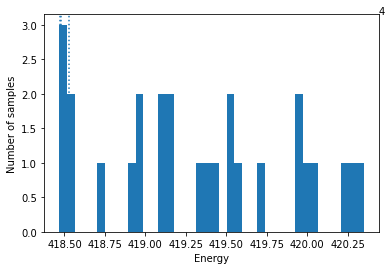

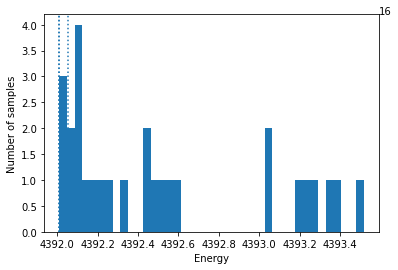

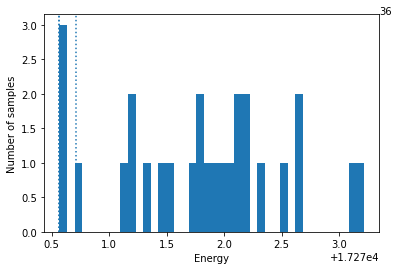

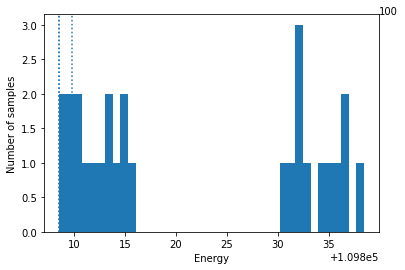

In [28]:
for i,row in dfsolutions[-4:].iterrows():
    f = row.filename
    with open(f,'rb') as ff:
        sampleset = pickle.load(ff)
    energies  = [s.energy for s in sampleset.record]
    plt.hist([s.energy for s in sampleset.record], bins=40)
    plt.xlabel('Energy')
    plt.ylabel('Number of samples')
    plt.text(1,1, row.n_cells, transform=plt.gca().transAxes)
    for q in [0.001,0.01, 0.1]:
        plt.axvline(np.percentile(energies,q*100),linestyle=':')
    plt.show()

In [29]:
#qubomodel.dqm.to_numpy_vectors()[2].row_indices[:100]

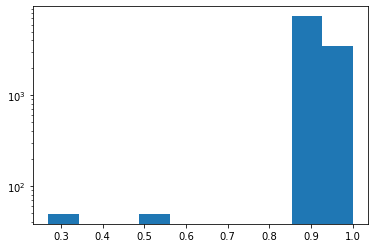

In [28]:
foo = qubomodel.constraint['water_less_equal_58.0']['penalty']
#amin, amax =foo[foo!=0].min(), foo[foo!=0].max()
#(foo-amin)/(amax - amin)
plt.hist(foo[foo>0].flatten())
plt.yscale('log')

### Display initial and penalty from constraints

In [29]:
first_constraint = [k for k,w in qubomodel.constraint.items() if 'water' in k][0]
second_constraint = [k for k,w in qubomodel.constraint.items() if 'nutrient' in k][0]
try:
    third_constraint = [k for k,w in qubomodel.constraint.items() if 'water' in k][1]
except:
    third_constraint = ''

In [32]:
weights

array([0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ,
       0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152,
       0.79172504, 0.52889492, 0.56804456, 0.92559664, 0.07103606,
       0.0871293 ])

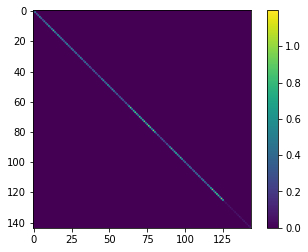

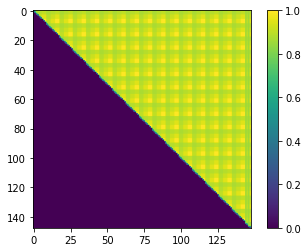

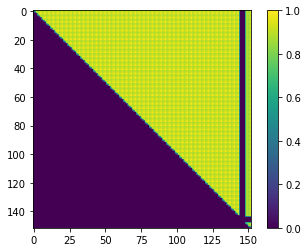

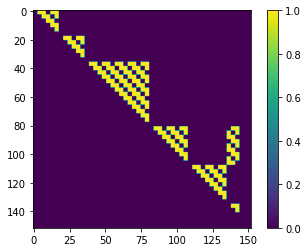

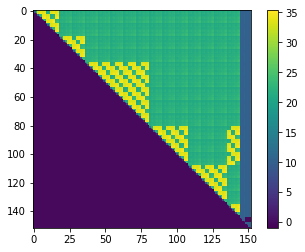

In [31]:
nprescript = len(water)*len(nutrients)
plt.imshow(np.concatenate([v for k,v in qubomodel.base_linear_biases.items()])*np.eye(nprescript*ngridcells))
plt.colorbar()
plt.show()
plt.imshow(qubomodel.constraint[first_constraint]['penalty'])
plt.colorbar()
plt.show()
plt.imshow(qubomodel.constraint[second_constraint]['penalty'])
plt.colorbar()
plt.show()
if third_constraint in qubomodel.constraint:
    plt.imshow(qubomodel.constraint[third_constraint]['penalty'])
    plt.colorbar()
    plt.show()
    penalty3 = qubomodel.constraint[third_constraint]['penalty']#[:36,:36]
else:
    penalty3 = 0
    
orig = np.concatenate([v for k,v in qubomodel.base_linear_biases.items()])*np.eye(nprescript*ngridcells)
penalty1 = qubomodel.constraint[first_constraint]['penalty']#[:36,:36]
penalty2 = qubomodel.constraint[second_constraint]['penalty']#[:36,:36]

finalmap =(-qubomodel._pad_zeroes(orig,penalty2.shape[0]) + 
                llambda*penalty3 +  
                llambda*qubomodel._pad_zeroes(penalty1,penalty2.shape[0])+ 
                llambda*penalty2)
plt.imshow(finalmap, interpolation='nearest')
plt.colorbar()
plt.show()

In [407]:
qubomodel.dqm.get_linear('0'), finalmap[5,5], llambda

(array([20.29414729, 20.08462995, 20.17678544, 20.16563711, 19.9004152 ,
        19.93686612, 20.17678544, 19.85585896, 19.83660531]),
 19.936866122965853,
 12.41407796345973)

In [161]:
a,b,c,d,e,f = 0.413,1.949,1.352,-2.472,1.218,-2.033

Maximize yield, $Y$,  over all cells

$Y = \sum_i \eta_i(\mathrm{a} + \mathrm{b} n_i + \mathrm{c} w_i + \mathrm{d} n_i^2 + \mathrm{e} n_i w_i + \mathrm{f} w_i^2)$

subject to:
- $\sum_i w_i <= W_{tot}$
- $\sum_i n_i <= N_{tot}$

where $w_i$ and $n_i$ are the prescribed water and nutrients for cell, $i$

PLUS zone-linking constraint

$w_i = w_j$ for preset cells, $i$ and $j$ so just replace these in the equation?



In [30]:
import random
Nwaterzones = 1000
Nnutrientzones = int(1e6)
ii = 0
zone_restrictions = {}
random.seed(0)
for i,j in enumerate(np.sort(random.sample(range(Nnutrientzones), Nwaterzones-1))):
    zone_restrictions[i] = np.arange(ii,j)
    #print(i,ii,j)
    ii = j

zone_restrictions[i+1] = np.arange(ii, Nnutrientzones)
len(zone_restrictions)
#zone_restrictions

1000

In [31]:
"""
zone_restrictions = {'a':[0,1],
                         'b':[2,3], 
                         'c':[4,5,6,7,8],
                         'd':[9,10,11,15],
                         'e':[12,13,14],
                         'f':range(16,1001,1),
                    'g':range(1001,100001,1)}
"""
cc = {}
for key,value in zone_restrictions.items():
    for v in value:
        cc[v] = key
len(cc)

1000000

In [33]:
import gurobipy as gp
from gurobipy import GRB

In [106]:
dfgurobi = pd.DataFrame()

In [109]:
nfarms = [4,16,36,100,1000,1e4,1e5,1e6]
water_dict = {4:2, 16:5, 36:10, 100:15, 1000:100, 1e4:500, 1e5:1000, 1e6:2000}
wr_f, nr_f = 4./6., 6./8.
wr_f, nr_f = 1.,1.
for ngridcells in nfarms:
    Nnutrientzones = int(ngridcells)
    Nwaterzones = water_dict[Nnutrientzones]
    ii = 0
    zone_restrictions = {}
    random.seed(0)
    for i,j in enumerate(np.sort(random.sample(range(Nnutrientzones), Nwaterzones-1))):
        zone_restrictions[i] = np.arange(ii,j)
        ii = j
    zone_restrictions[i+1] = np.arange(ii, Nnutrientzones)
    cc = {}
    for key,value in zone_restrictions.items():
        for v in value:
            cc[v] = key
    np.random.seed(0)
    weights = np.random.uniform(0,1,int(ngridcells))
    Wtotal = np.ceil(w_peak*ngridcells * wr_f)
    Ntotal = np.ceil(n_peak*ngridcells * nr_f)
    
    obj = gp.LinExpr()
    m = gp.Model('mip1')
    totalw = 0
    totaln = 0
    #### SET ZONE LINKING CONSTRAINT ####
    wdict ={}
    
    for i in range(int(ngridcells)):
        n = m.addVar(vtype=GRB.CONTINUOUS, name='n{}'.format(i))
        jj = cc[i]
        if jj not in wdict:
            wdict[jj] = m.addVar(vtype=GRB.CONTINUOUS, name='w{}'.format(jj))
        w = wdict[jj]
        totalw += w
        totaln += n
        obj += get_yield(w,n)*weights[i]
    m.setObjective(obj, GRB.MAXIMIZE)
    m.addConstr(totalw <= Wtotal)
    m.addConstr(totaln <= Ntotal)
    m.optimize()
    nt = 0
    for v in m.getVars():
        if v.varName[0]=='n':
            nt = nt + v.x
            i = int(v.varName[1:])
        #print('{:s} {:g}'.format(v.varName, v.x))
    print('Ntotal', nt, 'out of', Ntotal)
    print('Total yield: {:g} out of {}'.format(m.objVal, get_yield(4., 6.)*weights.sum()))
    dfgurobi = dfgurobi.append(pd.DataFrame({'n_grids':ngridcells,'n_waterzones':Nwaterzones,'wr_f':wr_f,'nr_f':nr_f,'objVal':m.objVal,'Runtime':m.Runtime},index=[0]), ignore_index=True)

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2 rows, 6 columns and 6 nonzeros
Model fingerprint: 0xd721c003
Model has 10 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [6e-02, 2e-01]
  QObjective range [9e-03, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 3e+01]
Presolve time: 0.03s
Presolved: 2 rows, 6 columns, 6 nonzeros
Presolved model has 10 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 4
 AA' NZ     : 1.100e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -6.17239017e+05  6.20226206e+05  4.00e+03 6.41e-01  1.00e+06     0s
   1  -2.21518443e+02  1.12692486e+04  9.21e+01 3.11e-08  

  12   5.87607426e+01  5.87607514e+01  3.56e-11 4.44e-16  7.47e-08     0s
  13   5.87607460e+01  5.87607473e+01  1.89e-10 2.22e-16  1.05e-08     0s
  14   5.87607465e+01  5.87607467e+01  5.39e-10 2.22e-16  1.47e-09     0s

Barrier solved model in 14 iterations and 0.09 seconds
Optimal objective 5.87607465e+01

Ntotal 799.947153302187 out of 800.0
Total yield: 58.7607 out of 54.44387618042041
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2 rows, 1100 columns and 1100 nonzeros
Model fingerprint: 0xa17cad69
Model has 2100 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [1e-04, 2e+00]
  QObjective range [9e-06, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+03, 8e+03]
Presolve time: 0.04s
Presolved: 2 rows, 1100 columns, 1100 nonzeros
Presolved model has 2100 quadratic objective terms
Ordering time: 0.00s

Barrier

   2  -2.93660438e+11  2.99624527e+11  4.95e+08 8.02e+03  1.11e+07    14s
   3  -2.06734683e+11  2.09909554e+11  1.39e+08 2.26e+03  4.04e+06    16s
   4  -1.37658644e+10  1.59554252e+10  1.26e+07 2.04e+02  4.17e+05    17s
   5  -1.13342148e+07  2.13935454e+09  2.80e+05 4.54e+00  1.13e+04    18s
   6  -1.06642771e+06  1.31851603e+09  2.47e+03 4.03e-02  1.37e+03    20s
   7   2.39762242e+05  2.80419688e+08  4.23e-08 4.03e-08  2.80e+02    22s
   8   4.64227464e+05  1.49577817e+07  1.85e-09 1.76e-09  1.45e+01    24s
   9   5.67998740e+05  3.05322446e+06  3.38e-14 9.65e-14  2.48e+00    25s
  10   6.15154569e+05  8.86528070e+05  6.66e-14 5.68e-14  2.71e-01    26s
  11   6.21829340e+05  6.32627335e+05  1.60e-14 6.04e-14  1.08e-02    28s
  12   6.21900009e+05  6.22880355e+05  3.38e-14 4.62e-14  9.78e-04    31s
  13   6.21902165e+05  6.21936460e+05  2.49e-14 6.39e-14  3.42e-05    32s
  14   6.21902234e+05  6.21904759e+05  3.66e-13 2.66e-14  2.52e-06    34s
  15   6.21902238e+05  6.21902305e+05 

In [110]:
dfgurobi

,n_grids,n_waterzones,wr_f,nr_f,objVal,Runtime
0,4.0,2,0.666667,0.75,2.778638,0.069440
1,16.0,5,0.666667,0.75,10.751229,0.054815
2,36.0,10,0.666667,0.75,23.760871,0.093263
3,100.0,15,0.666667,0.75,55.746155,0.076200
4,1000.0,100,0.666667,0.75,582.827135,0.173925
5,10000.0,500,0.666667,0.75,5833.011366,0.531537
6,100000.0,1000,0.666667,0.75,58622.635985,5.113334
7,1000000.0,2000,0.666667,0.75,587175.629765,51.865134
8,4.0,2,1.000000,1.00,2.997296,0.106477
9,16.0,5,1.000000,1.00,11.347247,0.060623


In [50]:
dfsolutions.columns, dfgurobi.columns

(Index(['n_cells', 'n_prescriptions', 'n_constraints', 'n_slacks',
        'n_dqm_cases', 'n_dqm_variables', 'n_dqm_case_interactions',
        'n_dqm_variable_interactions', 'filename', 'Wconstraint',
        'Wconstraint_percent_optimal', 'Nconstraint',
        'Nconstraint_percent_optimal', 'first_energy', 'qpu_access_time',
        'charge_time', 'run_time', 'llambda', 'solution', 'Wused', 'Nused',
        'dqm_slack', 'n_repeats', 'Yield', 'Optimal Yield'],
       dtype='object'),
 Index(['n_grids', 'n_waterzones', 'Runtime'], dtype='object'))

In [111]:
#dfsolutions

In [142]:
dfsolutions.tail(10)

,n_cells,n_prescriptions,n_constraints,n_slacks,n_dqm_cases,n_dqm_variables,n_dqm_case_interactions,n_dqm_variable_interactions,filename,Wconstraint,...,charge_time,run_time,llambda,solution,Wused,Nused,dqm_slack,n_repeats,Yield,Optimal Yield
27,36,9,3,12,348,48,58926,1092,./savedfiles/qubo36_1.0_1.0_lambda12.162667873...,216.0,...,4987560,4987560,12.162668,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",216,284,False,5.0,25.017461,25.022621
28,4,30,3,8,136,12,7368,50,./savedfiles/qubo4_0.6666666666666666_0.75_lam...,16.0,...,4995501,4995501,8.888665,"{0: {'water': 4, 'nutrients': 6}, 1: {'water':...",16,24,False,5.0,2.777099,2.997296
29,16,30,3,12,504,28,119640,342,./savedfiles/qubo16_0.6666666666666666_0.75_la...,64.0,...,4993439,4993439,11.976794,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",66,100,False,5.0,10.707391,11.347247
30,36,30,3,14,1108,50,597408,1176,./savedfiles/qubo36_0.6666666666666666_0.75_la...,144.0,...,5056421,5056421,12.162668,"{0: {'water': 4, 'nutrients': 6}, 1: {'water':...",156,236,False,5.0,24.086540,25.022621
31,4,20,3,8,96,12,3728,50,./savedfiles/qubo4_0.6666666666666666_0.75_lam...,16.0,...,4997801,4997801,8.888665,"{0: {'water': 4, 'nutrients': 8}, 1: {'water':...",14,26,False,1.0,2.722339,2.997296
32,16,20,3,12,344,28,55800,342,./savedfiles/qubo16_0.6666666666666666_0.75_la...,64.0,...,5000000,5002831,11.976794,"{0: {'water': 6, 'nutrients': 6}, 1: {'water':...",68,98,False,1.0,10.616531,11.347247
33,36,20,3,14,748,50,272328,1176,./savedfiles/qubo36_0.6666666666666666_0.75_la...,144.0,...,5000000,5013314,12.162668,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",152,238,False,1.0,23.904112,25.022621
34,100,20,3,17,2034,117,2048256,6714,./savedfiles/qubo100_0.6666666666666666_0.75_l...,400.0,...,7138050,7138050,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",454,688,False,1.0,57.477491,58.760747
35,100,20,3,18,2036,118,2052288,6822,./savedfiles/qubo100_1.0_1.0_lambda12.28391315...,600.0,...,7223228,7223228,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",444,724,False,1.0,55.846064,58.760747
36,100,20,3,18,2036,118,2052288,6822,./savedfiles/qubo100_1.0_1.0_lambda12.28391315...,600.0,...,7239588,7243846,12.283913,"{0: {'water': 6, 'nutrients': 8}, 1: {'water':...",588,774,False,5.0,58.670499,58.760747


In [92]:
dfsolutions_keep = dfsolutions.drop([15,16,17,18,35])

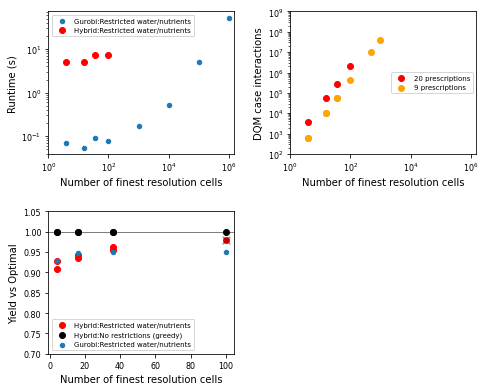

In [157]:
fig, axes = plt.subplots(2,2,figsize=(183./25.4, 183./25.4*0.8), sharex=False,sharey=False)
ax_flat = axes.flatten()
ind = dfgurobi.nr_f==0.75
dfgurobi[ind].plot.scatter(x='n_grids',y='Runtime',ax=ax_flat[0],label='Gurobi:Restricted water/nutrients')
x,y = dfsolutions_keep[-5:-1].n_cells, dfsolutions[-5:-1].run_time*1e-6
ax_flat[0].scatter(x,y,color='red', label='Hybrid:Restricted water/nutrients')
ax_flat[0].set_yscale('log')
ax_flat[0].set_xscale('log')
ax_flat[0].set_ylabel('Runtime (s)')
ax_flat[0].set_xlim(1,1.5e6)
ax_flat[0].set_xlabel('Number of finest resolution cells')
ax_flat[0].legend(fontsize=7)

x,y = dfsolutions_keep[-5:-1].n_cells, dfsolutions_keep[-5:-1].n_dqm_case_interactions #un_time*1e-6
ax_flat[1].scatter(x,y,color='red',label='20 prescriptions')
ind = ((dfsolutions_keep.n_prescriptions==9) & 
    (dfsolutions_keep.dqm_slack==False) & (dfsolutions_keep.n_constraints==3) &
       (dfsolutions_keep['Nconstraint_percent_optimal']==60))
x,y = dfsolutions_keep[ind].n_cells, dfsolutions_keep[ind].n_dqm_case_interactions #un_time*1e-6
ax_flat[1].scatter(x,y, color='orange',label='9 prescriptions')
ax_flat[1].legend(fontsize=7,loc=5)
ax_flat[1].set_xlabel('Number of finest resolution cells')
ax_flat[1].set_xlim(1,1.5e6)
ax_flat[1].set_ylabel('DQM case interactions')
ax_flat[1].set_yscale('log')
ax_flat[1].set_ylim(1e2,1e9)
ax_flat[1].set_xscale('log')

for ii, color,label in zip([75,100], ['red','black'],['Hybrid:Restricted water/nutrients','Hybrid:No restrictions (greedy)']):
    ind = dfsolutions_keep.Nconstraint_percent_optimal == ii
    x,y = dfsolutions_keep[ind].n_cells, dfsolutions_keep[ind].Yield/dfsolutions_keep[ind]['Optimal Yield']
    ax_flat[2].scatter(x,y,color=color, label=label)
    if ii==75:
        ax_flat[2].scatter(x[-1:],y[-1:], marker='x', color='k',alpha=0.4,s=60)
    ax_flat[2].set_ylabel('Yield vs Optimal')
ax_flat[2].axhline(1,lw=0.5,color='k')
#x,y = dfsolutions_keep[-4:].n_cells, dfsolutions_keep[-4:]['Optimal Yield']/dfsolutions_keep[-4:]['Optimal Yield']
#ax_flat[2].scatter(x,y,edgecolor='black',facecolor='none',s=50, label='Optimal Yield')
ax_flat[2].set_ylim(0.7,1.05)
ax_flat[2].set_xlabel('Number of finest resolution cells')
ind = (dfgurobi.nr_f == 0.75) & (dfgurobi.n_grids < 101)
x, y = dfgurobi[ind].n_grids, dfgurobi[ind].objVal.values/dfsolutions_keep[-5:-1]['Optimal Yield']
ax_flat[2].scatter(x,y,color='C0', s=20,label='Gurobi:Restricted water/nutrients')
ax_flat[2].legend(fontsize=7)
for i in range(3):
    ax_flat[i].tick_params(labelsize=8)
ax_flat[3].set_visible(False)

fig.subplots_adjust(wspace=0.3,hspace=0.4,top=0.95,right=0.95)
fig.savefig('Boltz_benchmarking.pdf')

In [101]:
dfgurobi

,n_grids,n_waterzones,Runtime
0,4.0,2,0.104881
1,16.0,5,0.080040
2,36.0,10,0.108105
3,100.0,15,0.080465
4,1000.0,100,0.246248
5,10000.0,500,0.483534
6,100000.0,1000,3.824784
7,1000000.0,2000,43.561371


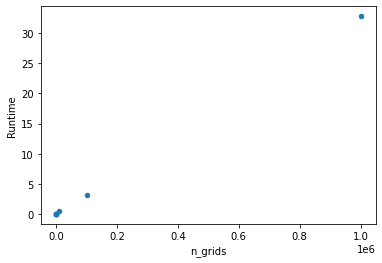

In [302]:
dfgurobi.to_csv('./GUROBI_summary_DEC7.csv', index=False)
dfgurobi.plot.scatter(x='n_grids', y='Runtime')

In [158]:
from cvxopt import matrix, solvers
P = 2*matrix([ [3.0, 0.0], [0.0, 4.0] ])
q = matrix([5.0, 1.0])
G = matrix([[-1.0,0.0],[0.0,-1.0]])
h = matrix([0.0,0.0])
A = matrix([1.0, 2.0], (1,2))
b = matrix(1.0)
sol=solvers.qp(P, q, G, h, A, b)
print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  5.3389e-01  7.8359e-01  4e+00  2e+00  5e-01
 1:  9.9750e-01  1.1337e+00  5e-01  3e-01  6e-02
 2:  1.5118e+00  1.4587e+00  5e-02  2e-16  9e-16
 3:  1.5001e+00  1.4996e+00  5e-04  1e-16  5e-16
 4:  1.5000e+00  1.5000e+00  5e-06  2e-16  1e-16
 5:  1.5000e+00  1.5000e+00  5e-08  1e-16  1e-16
Optimal solution found.
[ 3.50e-09]
[ 5.00e-01]



In [177]:
m = gp.Model('mip1')
x = m.addVar(vtype=GRB.BINARY, name='x')
y = m.addVar(vtype=GRB.BINARY, name='y')
z = m.addVar(vtype=GRB.BINARY, name='z')
# Set objective
m.setObjective(x + y + z * 2,GRB.MAXIMIZE)
# Add constraints
m.addConstr(x + 2*y + 3 * z <= 4, 'c0')
m.addConstr(x + y >= 1, 'c1')
m.optimize()

Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2 rows, 3 columns and 5 nonzeros
Model fingerprint: 0xf43f5bdf
Variable types: 0 continuous, 3 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 2.0000000
Presolve removed 2 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds
Thread count was 1 (of 4 available processors)

Solution count 2: 3 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e+00, best bound 3.000000000000e+00, gap 0.0000%


In [223]:
#print(qubomodel.dqm.get_linear('0'))
#for ll in qubomodel.slack_labels:
#    print('='*len(ll))
#    print(ll)
#    print('-'*len(ll))
#    print(qubomodel.dqm.get_linear(ll))
#    print(qubomodel.dqm.get_quadratic(ll,'1'))
#    print(qubomodel.dqm.get_quadratic(ll,'2'))

In [231]:
class Slack():
    def __init__(values, labels):
        self.values = values
        self.labels = labels
    def set_labelvalues(self, x):
        try:
            assert isinstance(x, dict)
        except:
            print('x is not of type Dict')
            return
        self.labels = x.keys()
        self.values = x.values()
    def add_labelvalues(self, x):
        try:
            assert isinstance(x, dict)
        except:
            print('x is not of type Dict')
            return
        self.labels.append(x.keys())
        self.values.append(x.values())

dict_values(['2'])

In [227]:
qubomodel.solve_dqm()
qubomodel.sampleset

SampleSet(rec.array([([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1], 296.64610182, 1),
           ([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1], 296.64610182, 1),
           ([0, 0, 6, 6, 0, 0, 0, 0, 1, 1, 1, 1, 1], 299.23419047, 1),
           ([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1], 296.64610182, 1),
           ([0, 0, 3, 4, 0, 0, 0, 0, 1, 0, 0, 0, 0], 297.49746728, 1),
           ([6, 6, 3, 3, 0, 0, 0, 0, 1, 1, 1, 0, 1], 302.87510593, 1),
           ([3, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 297.52553099, 1),
           ([3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 297.14559122, 1),
           ([3, 3, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 297.14559122, 1),
           ([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1], 296.64610182, 1),
           ([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1], 296.64610182, 1),
           ([0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], 297.00657315, 1),
           ([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1], 296.64610182, 1),
           ([4, 3, 3, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0], 299.2873926 , 

In [225]:
#filename = './savedfiles/qubo{}_{}_{}_lambda{}_2constraints_{}prescriptions.pickle'.format(ngridcells,wr_f,nr_f,llambda,len(water)*len(nutrients))

filename

'./savedfiles/qubo4_0.6_0.6_lambda8.88866512529448_3constraints_9prescriptions.pickle'

In [128]:
#sampleset.sample
#qubomodel.sampleset.first.energy#samples()
pickle.dump(qubomodel.sampleset, open(filename,'wb'))

In [133]:
dfsummary2 = dfsummary2.append(dict_working, ignore_index=True)


In [134]:
#dfsummary.loc[2,'lambda'] = 10
#dfsummary.loc[3,'lambda'] = 10
dfsummary2.to_csv('DWAVE_summary_5DEC2020.csv')
dfsummary2

,ngridcells,Wconstraint,Wconstraint_percent_of_optimal,Nconstraint,Nconstraint_percent_of_optimal,Water_used,Nutrients_used,qpu_access_time,charge_time,run_time,energy,filename,Nconstraints,Prescription_size,lambda
0,4,15.0,60.0,20.0,60.0,12,20,295468,4942841,4942841,129.793309,./savedfiles/qubo4_0.6_0.6_lambda8.88866512529...,3.0,"(3, 3)",8.888665
1,16,58.0,60.0,77.0,60.0,57,80,298097,4993632,4993632,3055.337065,./savedfiles/qubo16_0.6_0.6_lambda11.976793803...,3.0,"(3, 3)",11.976794


In [676]:
#dfsummary.Prescription_size = dfsummary.Prescription_size.astype(str).apply(lambda x: '({}, {})'.format(*tuple([
#    i.strip().strip('(').strip(')') for i in x.split(',')])))

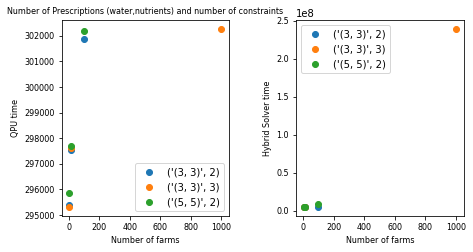

In [41]:
fig, axes =plt.subplots(1,2,figsize=(183./25.4, 183./25.4*0.5))
chsize=8
ax = axes[0]
for name,group in dfsummary[dfsummary.Wconstraint_percent_of_optimal==60].groupby(
    ['Prescription_size','Nconstraints']):
    ax.scatter(group['ngridcells'],group['qpu_access_time'],label=name)
ax.set_xlabel('Number of farms',fontsize=chsize)
ax.set_ylabel('QPU time', fontsize=chsize)
ax.set_title('Number of Prescriptions (water,nutrients) and number of constraints',fontsize=chsize)
ax.legend()
ax.tick_params(axis='both',labelsize=chsize)

ax = axes[1]
for name,group in dfsummary[dfsummary.Wconstraint_percent_of_optimal==60].groupby(
    ['Prescription_size','Nconstraints']):
    ax.scatter(group['ngridcells'],group['run_time'],label=name)
ax.set_xlabel('Number of farms',fontsize=chsize)
ax.set_ylabel('Hybrid Solver time',fontsize=chsize)
ax.tick_params(axis='both',labelsize=chsize)
#ax.set_title('Number of Prescriptions (x,x) and number of constraints')
ax.legend()
fig.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
# %load test_with_timing.py
from boltz import BQM, DQM, Solver
from boltzKB import QUBO
import numpy as np
import matplotlib.pyplot as plt
import time

# number of farms
ngridcells = 4

# fraction of optimal water available
wr_f = 0.8
# fraction of optimal nutrients available
nr_f = 0.8

# yield efficiency for each grid cell,
#     based on previous years' average yield maps
weights = [0.5, 1.0, 0.5, 0.8]

gridcells = np.arange(ngridcells)

# possible values of water, as integers
water = np.array([3,6,9])
w_peak = 6

# possible values of nutrients, as integers
nutrients = np.array([4,8,12])
n_peak = 8

# available water and nutrients
# This is set to a certain percentage of optimal values
Wtotal = np.ceil(w_peak*ngridcells * wr_f)
Ntotal = np.ceil(n_peak*ngridcells * nr_f)


# Variables
primary_variable = {'gridcells':gridcells}
secondary_variables = {'water':water, 'nutrients':nutrients}


# Defining Models
bqm = BQM(primary_variable, secondary_variables,weight=weights)
dqm = DQM(primary_variable, secondary_variables,weight=weights)
#qubo = QUBO((primary_variable, secondary_variables,weight=weights)

# Prepare Constraint

### DQM
dqm_constraints = {
    'water1':{
        'lhs':'water',
        'rhs':Wtotal,
        'kind':'less_equal',
        'll': 10
    },
    'nutrients1':{
        'lhs':'nutrients',
        'rhs':Ntotal,
        'kind':'less_equal',
        'll':10
    },
     'water2':{
         'lhs':'water',
         'rhs':{'a':[0,1],'b':[2,3]},
         'kind':'many_to_one',
         'll':1.0
     }
}
### BQM
bqm_constraints = {
    'Total Water Constraint':{
        'lhs':bqm.TotalWaterConstraint,
        'rhs':Wtotal,
        'kind':'less_equal',
        'll': 10
    },
    'Total Nutrients Constraint':{
        'lhs':bqm.TotalNutrientConstraint,
        'rhs':Ntotal,
        'kind':'less_equal',
        'll':10
    }
}

for c in range(len(bqm.CellUniqueConstraints)):
    bqm_constraints['Cell {} constraint'.format(c)] = {
        'lhs':bqm.CellUniqueConstraints[c],
        'rhs':1,
        'kind':'equal',
        'll':10
    }
# Adding constraint:
### DQM
for _, constraint in dqm_constraints.items():
    dqm.add_constraint(constraint['lhs'],
                             constraint['rhs'],
                             kind=constraint['kind'], 
                             ll=constraint['ll'])
### BQM
for _, constraint in bqm_constraints.items():
    bqm.add_constraint(constraint['lhs'],
                             constraint['rhs'],
                             kind=constraint['kind'], 
                             ll=constraint['ll'])
### Build QUBO and Summerize
dqm.build_qm()
dqm.summarize()
print('\n')
bqm.build_qm()
bqm.summarize()


### Timing

list_of_num_grid = np.arange(4,50)
#print(list_of_num_grid)
list_of_run_time = np.zeros(list_of_num_grid.shape)

for g in list_of_num_grid:
    # Variables
    grid = np.arange(g)
    weights = np.ones(g); 
    primary_variable_x = {}
    primary_variable_x['cell ' + str(g)] = {'gridcells': grid}; 
    secondary_variables_x = {'water':water, 'nutrients':nutrients}
    tmp_bqm = BQM(primary_variable_x['cell ' + str(g)], secondary_variables_x,weight=weights)
    ### BQM Constraint
    bqm_constraints = {
        'Total Water Constraint':{
            'lhs':tmp_bqm.TotalWaterConstraint,
            'rhs':Wtotal,
            'kind':'less_equal',
            'll': 10
        },
        'Total Nutrients Constraint':{
            'lhs':tmp_bqm.TotalNutrientConstraint,
            'rhs':Ntotal,
            'kind':'less_equal',
            'll':10
        }
    }

    for c in range(len(tmp_bqm.CellUniqueConstraints)):
        bqm_constraints['Cell {} constraint'.format(c)] = {
            'lhs':tmp_bqm.CellUniqueConstraints[c],
            'rhs':1,
            'kind':'equal',
            'll':10
        }
    ### Adding Constraint
    for _, constraint in bqm_constraints.items():
        tmp_bqm.add_constraint(constraint['lhs'],
                                 constraint['rhs'],
                                 kind=constraint['kind'], 
                                 ll=constraint['ll'])
    ### Build-Solve and Timing
    tmp_bqm.build_qm()
    #tmp_bqm.summarize()
    start = time.time()
    sampleset = Solver(tmp_bqm.qm)
    #qubo_solution = sampleset.first
    #SAS_solution = tmp_bqm.bqm.convert_solution(qubo_solution)
    list_of_run_time[g-4] = time.time() - start
    print('{} farm sampling in: {}'.format(g,list_of_run_time[g-4]))
plt.plot(list_of_num_grid,list_of_run_time)

---

In [608]:
endofdocument

NameError: name 'endofdocument' is not defined

# Appendix/Notes

In [44]:
# yield for a given cell is dependent on:
#  POSITIVE
#  - available nutrients 
#     - soil type, soil testing and nutrients application
#  - available water
#     - soil type, rain, irrigation
#  - PAR photosynthetically active radiation
#     - cloud cover, sun angle
#  - air temperature
#  NEGATIVE
#   - excess water, nutrients?
#   - fungus growth, pests
#
# How to get realistic model of yield as a function of inputs?

def get_yield(water, nutrients):
    a,b,c,d,e,f = 0.413,1.949,1.352,-2.472,1.218,-2.033
    # function maximum if concave (down)
    maxn = (2*f*b/e - c)/(e - 4*f*d/e)
    maxw = (2*d*c - e*b) / (e**2 - 4*d*f)
    # normalize water and nutrients
    w_min = w_peak - w_range*maxw
    n_min = n_peak - n_range*maxn
    
    w = (water - w_min) / w_range
    n = (nutrients - n_min) / n_range
    
    return (a + b*n + c*w + d*(n)**2 + e*n*w + f*(w)**2)

class QUBO():
    def __init__(self, primary, secondary, 
                 func=get_yield, weight=None,**kwargs):

        # psize: number of primary (top-level) variables, 
        #       (each has to select from dsize variables)
        self.weight = weight
        self.primary = [vv for vv in primary.values()][0]
        psize = len(self.primary)
        self.psize = psize
        dvalues = np.array([i for i in product(*secondary.values())]).T
        labels = [k for k in secondary.keys()]
        self.secondary = {labels[i]:dvalues[i][:] for i in range(len(labels))}
        
        
        # dsize: number of discretized variables
        dsize = len(dvalues.T)
        self.dsize = dsize
        
        # keep track of size of QUBO we are solving
        self.qsize = psize*dsize
        
        # These are the initial base linear biases based on function, func
        self.base_linear_biases = {}
        for i,p in enumerate(self.primary):
            #print(p)
            self.base_linear_biases[p] = weight[i]*func(*dvalues)
        
        self.constraint = {}
        self.nslacks = 0
        self.slack_labels = []
        
    def add_constraint(self, lhs, rhs, ll=1.0, kind='less_equal',
                       slack_variables=None, normalize = True):
        # max_slack of zero is equivalent to an equality constraint
        """slackVar: list of possible values of slack variables
                These may be limited based on the constraints and the
                possible combinations of variables.
        """
        
        if kind == 'equal':
            max_slack = 0
            slack_variables = np.array([])
            label = '{}_{}_{}'.format(lhs,kind,rhs)
        elif kind == 'many_to_one':
            # map many primary variables ('grids') to the same value of lhs
            max_slack = 0
            slack_variables = np.array([])
            label = '{}_{}'.format(lhs,kind)
        else:
            # this assumes that lhs is Positive
            max_slack = rhs
            label = '{}_{}_{}'.format(lhs,kind,rhs)
            
            if slack_variables is None:
                slack_variables = np.array([2**k for k in range(int(np.floor(np.log2(max_slack)))+1)])

        print('{}. Adding {} slack variables'.format(lhs, len(slack_variables)))
        
        v = np.tile(self.secondary[lhs], self.psize)
        vnew = np.concatenate((v, np.zeros(self.nslacks),slack_variables))
        if kind in ['equal','less_equal']:
            # set diagonal
            result = (-2*rhs+1)*vnew*np.eye(len(vnew))
    
            # set off-diagonal elements
            result += 2*(1-np.eye(len(vnew)))*vnew.reshape(-1,len(vnew)).T * vnew
    
            # add constant (rhs**2)
            result += result+rhs**2
        elif kind in ['many_to_one']:
            # create vector for all primary variables
            primary_all = np.concatenate((np.repeat(self.primary, self.dsize),np.zeros(self.nslacks)))

            # find where lhs matches other lhs values
            matched = np.sqrt(vnew.reshape(-1,len(vnew)).T * vnew) % 1 == 0
            result = np.zeros_like(matched).astype(int)
            for _, pp in rhs.items():
                ind = np.isin(primary_all,pp)
                penalty_ = (~matched).astype(int)
        # remove penalties for grids not included in many_to_one zone
                penalty_[~ind,:] = 0
                penalty_[:,~ind] = 0
                result += penalty_
    
        # upper triangle
        result = np.triu(result)
    
        # zero out slack rows/columns from previous constraints
        result[len(v):len(v)+self.nslacks,:] = 0
        result[:,len(v):len(v)+self.nslacks] = 0
        
        if normalize:
            result = np.triu(self._normalize_array(result))
        
        self.constraint[label] = {
            'penalty': result,
            'lambda':ll,
            'slack_variables':slack_variables
        }
        self.slack_labels += ['{}_S{}'.format(label,ss) for ss in slack_variables]

        self.nslacks += len(slack_variables)
        self.qsize += len(slack_variables)
    
    def solve_dqm(self,maximum=True,sampler=LeapHybridDQMSampler):
        self.build_dqm(maximum=maximum)
        chosen_sampler = sampler()
        sampleset = chosen_sampler.sample_dqm(self.dqm)
        self.sampleset = sampleset
    
    def _normalize_array(self, a, amin=0, amax=1):
        return a/(a.max() - a.min())
    
    def _pad_zeroes(self, x, tsize):
        """ Pad array with zeroes so that it matches tsize.
        This is needed when adding slack variables.
        """
        # x is array
        # tsize is target size
        result = np.zeros((tsize,tsize))
        result[:x.shape[0],:x.shape[1]] = x
        return result
    
    def summarize(self):
        # number of variables in each field
        print('Number of primary variables:', self.psize)
        print('Number of secondary options:', self.dsize)
        print('Number of constraints:', len(self.constraint))
        print('Number of slack variables:', self.nslacks)
        # total number of variables
        print('Number of variables:', self.dqm.num_cases())
        print('Number of variable interactions:',self.dqm.num_case_interactions())
        print('Number of DQM variable interactions:', self.dqm.num_variable_interactions())
        print('Number of DQM variables:',self.dqm.num_variables())
    
    #def build_bqm(self.,maximum=True)
    
    def build_dqm(self, maximum=True):
        dqm = dimod.DiscreteQuadraticModel()
        if maximum:
            factor = -1.
        else:
            factor = 1.
        # Build penalty terms as fully-connected array
        penalty = 0
        for _,constraint in self.constraint.items():
            try:
                penalty+=constraint['penalty']*constraint['lambda']
            except:
                # add zeroes if needed
                penalty = self._pad_zeroes(penalty, constraint['penalty'].shape[0])
                penalty+=constraint['penalty']*constraint['lambda']

        # cycle through primary variables, adding linear terms
        nvariables = self.dsize
        for i,p in enumerate(self.primary):
            dqm.add_variable(nvariables, label=str(p))
            # add base linear terms
            biases = factor*self.base_linear_biases[p]
            #print(biases)
            # add linear terms from constraint
            biases -= factor*np.diag(
                    penalty[i*nvariables:(i+1)*nvariables,i*nvariables:(i+1)*nvariables])
            print(biases)
            dqm.set_linear(str(p),biases)
        # add slacks, linear terms
        slacks = np.diag(penalty[nvariables*self.psize:,nvariables*self.psize:])
        for s,ss in zip(slacks, self.slack_labels):
            nvariables = 1
            dqm.add_variable(nvariables, label=str(ss))
            bias = -factor*s
            dqm.set_linear(str(ss), [bias])
        
        combos = [i for i in product(self.primary, self.primary) if i[0]!=i[1]]

        nvariables = self.dsize
        for f1,f2 in combos:
            biases = -penalty[f1*nvariables:(f1+1)*nvariables,f2*nvariables:(f2+1)*nvariables]
            dqm.set_quadratic(str(f1),str(f2), biases)
        slacks = np.arange(nvariables*self.psize, 
                           nvariables*self.psize+self.nslacks+1)
        for s,ss in zip(slacks, self.slack_labels):  
            for f1 in self.primary:
                bias = -factor*penalty[s:s+1,f1*nvariables:(f1+1)*nvariables]
                dqm.set_quadratic(str(f1),
                              '{}'.format(ss), 
                              bias)
        self.dqm = dqm

## Constraints
$\sum_i v_i <= \mathrm{rhs}$

- each call to ``define_inequality`` adds new slack variables
- keep track of these

In [5]:
def define_inequality(v, rhs, skip=0, max_slack=0):
    
    # max_slack of zero is equivalent to an equality constraint
    
    slackVar = np.array([2**k for k in range(int(np.floor(np.log2(max_slack)))+1)])
    vnew = np.concatenate((v, slackVar))
    
    # set diagonal
    result = (-2*rhs+1)*vnew*np.eye(len(vnew))
    
    # set off-diagonal elements
    result += 2*(1-np.eye(len(vnew)))*vnew.reshape(-1,len(vnew)).T * vnew
    
    # add constant (rhs**2)
    result += result+rhs**2
    
    # upper triangle
    result = np.triu(result)
    
    # zero out skipped rows/columns
    if skip!=0:
        result[len(v)-skip:len(v),:] = 0
        result[:,len(v)-skip:len(v)] = 0
    #print(len(slackVar))
    return result





### Water and nutrient constraints

In [6]:

constraints = {
    'water': {'lhs':np.tile(prescription.water,ngridcells),
              'rhs': Wtotal,
              'constraint':'le',
              'lambda':10
             },
    'nutrients': {'lhs':np.tile(prescription.nutrients,ngridcells),
                  'rhs': Ntotal,
                  'constraint':'le',
                  'lambda':10
                 }
}

# determine number of additional binary slack values needed for all constraints
n_slackVar = 0
for kind, constraint in constraints.items():
    nbin_slacks=int(np.floor(np.log2(constraint['rhs'])))+1
    n_slackVar += nbin_slacks
    constraints[kind]['binarySlackVars'] = nbin_slacks

Nslackskip = 0
for kind, constraint in constraints.items():
    print(kind)
    if constraint['constraint'] in ['le']:
        penalty = define_inequality(np.concatenate((constraint['lhs'],np.zeros(Nslackskip))),
                                constraint['rhs'],
                                skip = Nslackskip,
                                max_slack=constraint['rhs'])
    
    Nslackskip += constraint['binarySlackVars']
    # add zeroes padding
    if Nslackskip < n_slackVar:
        print('Padding', kind, 'penalty')
        penalty = pad_zeroes(penalty,n_slackVar+len(constraint['lhs']))
    else:
        print('No padding needed. Last inequality')
    constraints[kind]['penalty'] = np.triu(normalize_array(penalty))

water
Padding water penalty
nutrients
No padding needed. Last inequality


### Water zone-grid cell constraint

In [7]:
additional_constraints = {
    'waterZones': {
        'water':True,
        'gridcells':[np.arange(0,ngridcells/2),np.arange(ngridcells/2,ngridcells)],
        'nutrients': False,
        'lambda':10
    }
}

gridcell_model = np.repeat(np.arange(ngridcells), len(prescription.water))

# look at connections between water_presc
water_model = np.tile(prescription.water, ngridcells)
water_model_matched = np.sqrt(water_model.reshape(-1,len(water_model)).T * water_model)%1==0

for kind,constraint in additional_constraints.items():
    penalty = np.zeros_like(water_model_matched).astype(int)
    for gridcells in constraint['gridcells']:
        ind = np.isin(gridcell_model,gridcells)
        fz = np.zeros_like(gridcell_model)
        fz[ind] = True
        if constraint['water']:
            penalty_ = (~water_model_matched).astype(int)
        else:
            penalty_ = np.zeros_like(water_model_matched)
        # remove penalties for grids not included in water zone
        penalty_[~ind,:] = 0
        penalty_[:,~ind] = 0
        penalty += np.triu(penalty_)
        
    # pad if needed
    print('Padding penalty with zeroes to account for slack variables.')
    penalty = pad_zeroes(penalty,n_slackVar+len(water_model))
    additional_constraints[kind]['penalty'] = np.triu(normalize_array(penalty))

Padding penalty with zeroes to account for slack variables.


In [8]:
#import pprint
#pprint.pprint(constraints)
#pprint.pprint(additional_constraints)

In [9]:
dqm = dimod.DiscreteQuadraticModel()
# field efficiencies
np.random.seed(0)
eta = np.random.uniform(0,1,ngridcells)

# each grid cell gets one prescription
for i in np.arange(ngridcells):
    nvariables = len(prescription)
    dqm.add_variable(nvariables, label=str(i))
    biases = -eta[i]*prescription.get_yield()

    for kind,constraint in constraints.items():
        biases += constraint['lambda']*np.diag(
            constraint['penalty'][i*nvariables:(i+1)*nvariables,i*nvariables:(i+1)*nvariables])
    
    for kind,constraint in additional_constraints.items():
        biases += constraint['lambda']*np.diag(
            constraint['penalty'][i*nvariables:(i+1)*nvariables,i*nvariables:(i+1)*nvariables])
    
    dqm.set_linear(str(i),biases)


combos = [i for i in product(np.arange(ngridcells), np.arange(ngridcells)) if i[0]!=i[1]]

for f1,f2 in combos:
    penalty = 0
    for kind,constraint in constraints.items():
        penalty += constraint['lambda']*(
            constraint['penalty'][f1*nvariables:(f1+1)*nvariables,f2*nvariables:(f2+1)*nvariables])
    for kind,constraint in additional_constraints.items():
        penalty += constraint['lambda']*(
            constraint['penalty'][f1*nvariables:(f1+1)*nvariables,f2*nvariables:(f2+1)*nvariables])

    dqm.set_quadratic(str(f1),str(f2), penalty)

nvariables_ = dqm.num_cases()
# know need to add the slack variables (#97 to 107 )
for kind,constraint in constraints.items():
    penalty = constraint['lambda']*(
            constraint['penalty'][:nvariables_+constraint['binarySlackVars'],
                                  nvariables_:nvariables_+constraint['binarySlackVars']
                                 ])
    # add all binary slack variables for constraint
    for i in np.arange(constraint['binarySlackVars']):
        slacknum = constraint['binarySlackVars']-i
        dqm.add_variable(1,label='s{}{}'.format(i,kind[0]))
        dqm.set_linear('s{}{}'.format(i,kind[0]),[penalty[-slacknum,-slacknum]])
    # now add quadratic terms
    for i in np.arange(constraint['binarySlackVars']):
        slacknum = constraint['binarySlackVars']-i
        penalty = constraint['lambda']*(
                    constraint['penalty'][-slacknum,:])
        penalty = penalty.reshape(1,len(penalty))
        #print(penalty.shape, slacknum)
        for f1 in np.arange(ngridcells):
            #print(nvariables,f1, i)
            dqm.set_quadratic(str(f1),
                              's{}{}'.format(i,kind[0]), 
                              penalty[:,f1*nvariables:(f1+1)*nvariables])
    nvariables_ += constraint['binarySlackVars']

# number of variables in each field
print('Number of grid cells:', ngridcells)
print('Number of prescriptions per field:',dqm.num_cases('3'))
# total number of variables
print('Number of variables:', dqm.num_cases())
print('Number of variable interactions:',dqm.num_case_interactions())
print('Number of DQM variable interactions:', dqm.num_variable_interactions())
print('Number of DQM variables:',dqm.num_variables())

Number of grid cells: 4
Number of prescriptions per field: 9
Number of variables: 46
Number of variable interactions: 486
Number of DQM variable interactions: 46
Number of DQM variables: 14


In [594]:
akdvna

NameError: name 'akdvna' is not defined

In [10]:
from neal import SimulatedAnnealingSampler

In [11]:
dqm_v = dqm.to_numpy_vectors()

In [54]:
dqm_v

DQMVectors(case_starts=array([ 0,  9, 18, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
      dtype=uint16), linear_biases=array([-0.08321875, -0.56689411, -1.03172686, -0.54183336, -1.03015076,
       -1.49962556, -0.9849516 , -1.47791105, -1.95202791, -0.2861997 ,
       -0.77132391, -1.23189329, -0.74575595, -1.23692947, -1.70354815,
       -1.18511803, -1.68234086, -2.15500885, -0.14903837, -0.63318354,
       -1.09663383, -0.60795832, -1.09720186, -1.56575053, -1.04985857,
       -1.54420049, -2.01784753, -0.0784237 , -0.56206483, -1.0269983 ,
       -0.53701606, -1.025266  , -1.49480827, -0.98022304, -1.47308178,
       -1.94723286,  2.10805085,  1.65254237,  0.74152542, -1.08050847,
       -4.72457627,  3.1737013 ,  2.69480519,  1.73701299, -0.17857143,
       -4.00974026]), quadratic=QuadraticVectors(row_indices=array([ 9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 13, 

In [53]:
[v for v in dqm_v.labels]

['0',
 '1',
 '2',
 '3',
 's0w',
 's1w',
 's2w',
 's3w',
 's4w',
 's0n',
 's1n',
 's2n',
 's3n',
 's4n']

In [97]:
# need to add in one-hot constraint
def dqm_to_bqm(dqm):
    dqm_v = dqm.to_numpy_vectors()
    nparams = len(dqm_v.linear_biases)
    vlabels = ['{}'.format(v) for v in dqm_v.labels]
    labels = np.empty(nparams,dtype=object)
    #print(vlabels)
    j = -1
    ii = 0
    for i in np.arange(nparams):
        if i in dqm_v.case_starts:
            ii = 0
            j+=1
        
        labels[i] = vlabels[j]
        if vlabels[j][0]!='s':
            labels[i] = '{}-{}'.format(labels[i],ii)
        ii += 1
    #print(labels)
    vt = dimod.BINARY
    offset = 0.0
    linear = {l:dqm_v.linear_biases[i] for i,l in enumerate(labels)}
    quadratic = {(i,j):k for i,j,k in zip(labels[dqm_v.quadratic.row_indices],
                                          labels[dqm_v.quadratic.col_indices],
                                          dqm_v.quadratic.biases)}
    bqm = dimod.BinaryQuadraticModel(linear, quadratic, offset, vt)
    return bqm

In [103]:
bqm = dqm_to_bqm(dqm)
bqm.quadratic

['0', '1', '2', '3', 's0w', 's1w', 's2w', 's3w', 's4w', 's0n', 's1n', 's2n', 's3n', 's4n']
['0-0' '0-1' '0-2' '0-3' '0-4' '0-5' '0-6' '0-7' '0-8' '1-0' '1-1' '1-2'
 '1-3' '1-4' '1-5' '1-6' '1-7' '1-8' '2-0' '2-1' '2-2' '2-3' '2-4' '2-5'
 '2-6' '2-7' '2-8' '3-0' '3-1' '3-2' '3-3' '3-4' '3-5' '3-6' '3-7' '3-8'
 's0w' 's1w' 's2w' 's3w' 's4w' 's0n' 's1n' 's2n' 's3n' 's4n']


{('0-0', '1-0'): 7.5412722870349995, ('0-0', '1-1'): 7.654908650671363, ('0-0', '1-2'): 7.768545014307726, ('0-0', '1-3'): 17.64720449042483, ('0-0', '1-4'): 17.760840854061193, ('0-0', '1-5'): 17.874477217697557, ('0-0', '1-6'): 17.75313669381466, ('0-0', '1-7'): 17.866773057451024, ('0-0', '1-8'): 17.980409421087387, ('0-0', '2-0'): 7.5412722870349995, ('0-0', '2-1'): 7.654908650671363, ('0-0', '2-2'): 7.768545014307726, ('0-0', '2-3'): 7.64720449042483, ('0-0', '2-4'): 7.760840854061193, ('0-0', '2-5'): 7.874477217697557, ('0-0', '2-6'): 7.75313669381466, ('0-0', '2-7'): 7.866773057451024, ('0-0', '2-8'): 7.980409421087387, ('0-0', '3-0'): 7.5412722870349995, ('0-0', '3-1'): 7.654908650671363, ('0-0', '3-2'): 7.768545014307726, ('0-0', '3-3'): 7.64720449042483, ('0-0', '3-4'): 7.760840854061193, ('0-0', '3-5'): 7.874477217697557, ('0-0', '3-6'): 7.75313669381466, ('0-0', '3-7'): 7.866773057451024, ('0-0', '3-8'): 7.980409421087387, ('0-1', '1-0'): 7.654908650671363, ('0-1', '1-1'): 

In [99]:
#sampler = LeapHybridDQMSampler()
#sampleset = sampler.sample_dqm(dqm)
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=500)

In [100]:
sample = sampleset.first.sample
energy = sampleset.first.energy

# check format of sample from DQM

In [93]:
import pickle

In [94]:
#pickle.dump(sampleset, open('first_trial.100x9.p','wb'))

In [95]:
prescription.water

array([5, 5, 5, 6, 6, 6, 7, 7, 7])

In [101]:
sample

{'0-0': 0,
 '0-1': 0,
 '0-2': 0,
 '0-3': 0,
 '0-4': 0,
 '0-5': 0,
 '0-6': 0,
 '0-7': 0,
 '0-8': 0,
 '1-0': 1,
 '1-1': 1,
 '1-2': 1,
 '1-3': 1,
 '1-4': 1,
 '1-5': 1,
 '1-6': 1,
 '1-7': 1,
 '1-8': 1,
 '2-0': 0,
 '2-1': 0,
 '2-2': 0,
 '2-3': 0,
 '2-4': 0,
 '2-5': 0,
 '2-6': 0,
 '2-7': 0,
 '2-8': 0,
 '3-0': 0,
 '3-1': 0,
 '3-2': 0,
 '3-3': 0,
 '3-4': 0,
 '3-5': 0,
 '3-6': 0,
 '3-7': 0,
 '3-8': 0,
 's0n': 0,
 's0w': 0,
 's1n': 0,
 's1w': 0,
 's2n': 0,
 's2w': 0,
 's3n': 1,
 's3w': 1,
 's4n': 1,
 's4w': 1}

In [47]:
residual = {'w':0, 'n':0}
total_yield = 0
waterused = 0
nutrientsused = 0
print('Peak yield is at w={},n={}'.format(w_peak,n_peak))

## LABELS ARE NOT REALLY PRESENT. slack?
for key,value in sample.items():
    #print(key)
    if value!=0:
        # slack variables
        if (key[0]=='s'):
            kind = key[-1]
            binValu = 2**int(key[1:-1])
            residual[kind] = residual[kind] + binValu
        else:
            f,prescription_number = int(key),value
            w = prescription.water[value]
            n = prescription.nutrients[value]
            print(value,w,n,f)
            #[int(i) for i in key.split('_')]
            total_yield += eta[f]*Prescription(w,n).get_yield()
            print('Grid cell {:} used {:} Water and {:} Nutrients (Yield {:.3f})'.format(
                f,w,n, eta[f]*Prescription(w,n).get_yield()))
            waterused +=w
            nutrientsused +=n
print('Water used: {:3d} (out of available {})'.format(waterused,Wtotal))
print('Nutri used: {:3d} (out of available {})'.format(nutrientsused,Ntotal))
print('\nUnused resources (residuals from inequality):')
print(residual)
print('\nWater zone restrictions:')
print(additional_constraints['waterZones']['gridcells'])
print('\nTotal Yield {:.3f}'.format(total_yield))

Peak yield is at w=6,n=8
1 5 8 18


IndexError: index 18 is out of bounds for axis 0 with size 4

In [487]:
# different yields for different grid cells
eta = [1.0*100,
       0.7*100,
       0.5*100,
       0.9*100]
#eta = [100.,100.,100.,100.]
#eta = [100.,1.]
#eta = [100]*4/


# number of grid cells in field
ngridcells = len(eta)

# ZONE definitions for fixed irrigation
#waterzones = {'a':[0,1,2,3,4], 'b':[5,6,7,8,9,10,11],
#              'c':[12,13,14,15,16,17,18,19,20,21,22,23,24],'d':[25,26,27,28,29,30]}

waterzones = {'a':[0,2], 'b':[1,3]}

try:
    assert (np.sort(np.array([v1 for v in waterzones.values() for v1 in v ]).flatten()) == np.arange(ngridcells)).all()
except:
    print('ERROR. Check that all grid cells have been assigned to a water zone.')


# CONSTRAINTS    
ll1, ll2 = 10, 10
onehotconstraint, zonelinking = True, True
ll3, ll4 = 10,10
waterconstraint, nutrientconstraint = True, True


In [457]:
H = 0
Wused=0
Nused=0
field_yield = prescription.get_yield()

for g in range(ngridcells):
    
    # only one prescription (nutrient+water) allowed per grid cell
    index = np.array([Binary('{}_{}_{}'.format(g,w,n)) 
                      for w,n in zip(prescription.water,prescription.nutrients)])
    H -= (eta[f]*prescription.get_yield()*index).sum() # on the order of 500
    # one-hot restriction
    onehot = index.sum()
    # water used
    Wused+=(prescription.water*index).sum()
    # nutrients used
    Nused+=(prescription.nutrients*index).sum()
    if onehotconstraint:
        H += ll1*(onehot - 1)**2
    
#zone-linking constraint
# penalize if water j != water j' when looking at cells in the same zone

for zone, gridcells in waterzones.items():
    # there are no linking constraints needed
    if len(gridcells)==1:
        continue
    # first grid cell. Comparing all others to this first grid cell.
    g = gridcells[0]
    print(zone, gridcells)
    notallowed = np.array([
                    Binary('{}_{}_{}'.format(g,w,n))*Binary('{}_{}_{}'.format(g1,w1,n1))
                                                   for g1 in gridcells[1:] 
                   for n in nutrients for n1 in nutrients
                   for w in water for w1 in water if (w!=w1)])
    H += ll2*notallowed.sum()
    print(zone)

# water constraint (possible values: 0 to 15)
slackVar = 8*Binary('I8w')+4*Binary('I4w')+2*Binary('I2w') + 1*Binary('I1w')
if waterconstraint:
    H+=ll3*(Wused + slackVar - Wtotal)**2

# nutrient constraint (possible values: 0 to 15)
slackVar = 8*Binary('I8n')+4*Binary('I4n')+2*Binary('I2n') + 1*Binary('I1n')
if nutrientconstraint:
    H+=ll4*(Nused + slackVar - Ntotal)**2


a [0, 2]
a
b [1, 3]
b


In [82]:
#def get_slack(value):
    

In [83]:
def get_slack(value,stride=1):
    #print(value/stride)
    kmin = int(np.floor(np.log2(value/stride)))+1
    print(kmin,value)
    slackVar= 0
    print(value/stride - 2**kmin)
    #if (value/stride-2**kmin)!=0:
    #    slackVar += get_slack(value-2**kmin)
    slackVar += np.array([2**k*Binary('I{}'.format(2**k)) for k in range(kmin)]).sum()
    return slackVar*stride
get_slack(32,stride=1)

6 32
-32.0


(((Binary(I1)*Num(1))+(Binary(I2)*Num(2))+(Binary(I4)*Num(4))+(Binary(I8)*Num(8))+(Binary(I16)*Num(16))+(Binary(I32)*Num(32)))*Num(1))

In [63]:
qubo

({('0_4_5', '0_4_6'): 18800.0,
  ('0_4_5', '0_4_7'): 20800.0,
  ('0_4_5', '0_4_8'): 22800.0,
  ('0_4_5', '0_4_9'): 24800.0,
  ('0_4_10', '0_4_5'): 26800.0,
  ('0_4_5', '0_5_5'): 18400.0,
  ('0_4_5', '0_5_6'): 20400.0,
  ('0_4_5', '0_5_7'): 22400.0,
  ('0_4_5', '0_5_8'): 24400.0,
  ('0_4_5', '0_5_9'): 26400.0,
  ('0_4_5', '0_5_10'): 28400.0,
  ('0_4_5', '0_6_5'): 20000.0,
  ('0_4_5', '0_6_6'): 22000.0,
  ('0_4_5', '0_6_7'): 24000.0,
  ('0_4_5', '0_6_8'): 26000.0,
  ('0_4_5', '0_6_9'): 28000.0,
  ('0_4_5', '0_6_10'): 30000.0,
  ('0_4_5', '0_7_5'): 21600.0,
  ('0_4_5', '0_7_6'): 23600.0,
  ('0_4_5', '0_7_7'): 25600.0,
  ('0_4_5', '0_7_8'): 27600.0,
  ('0_4_5', '0_7_9'): 29600.0,
  ('0_4_5', '0_7_10'): 31600.0,
  ('0_4_5', '1_4_5'): 16400.0,
  ('0_4_5', '1_4_6'): 18400.0,
  ('0_4_5', '1_4_7'): 20400.0,
  ('0_4_5', '1_4_8'): 22400.0,
  ('0_4_5', '1_4_9'): 24400.0,
  ('0_4_5', '1_4_10'): 26400.0,
  ('0_4_5', '1_5_5'): 18000.0,
  ('0_4_5', '1_5_6'): 20000.0,
  ('0_4_5', '1_5_7'): 22000.0,
  (

In [67]:
model = H.compile()
qubo,_ = model.to_qubo()
bqm = dimod.BinaryQuadraticModel.from_qubo(qubo)

sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=500)
print(len(sampleset))

500


In [71]:
min(sampleset, key=lambda x: x)

TypeError: '<' not supported between instances of 'SampleView' and 'SampleView'

In [65]:
decoded_samples = model.decode_sampleset(sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)
#print(best_sample.sample)
#[x.energy for x in decoded_samples]

AttributeError: 'Model' object has no attribute 'decode_sampleset'

In [66]:
residual = {'w':0, 'n':0}
total_yield = 0
waterused = 0
nutrientsused = 0
print('Peak yield is at w={},n={}'.format(w_peak,n_peak))
for key,value in best_sample.sample.items():
    #print(key)
    if value==1:
        if (key[0]=='I'):
            kind = key[-1]
            residual[kind] = residual[kind] + int(key[1:-1])
        else:
            f,w,n = [int(i) for i in key.split('_')]
            total_yield += eta[f]*Prescription(w,n).get_yield()
            print('Grid cell {:} used {:} Water and {:} Nutrients (Yield {:.3f})'.format(
                f,w,n, eta[f]*Prescription(w,n).get_yield()))
            waterused +=w
            nutrientsused +=n
print('Water used: {:3d} (out of available {})'.format(waterused,Wtotal))
print('Nutri used: {:3d} (out of available {})'.format(nutrientsused,Ntotal))
print('\nUnused resources (residuals from inequality):')
print(residual)
print('\nWater zone restrictions:')
print(waterzones)
print('\nTotal Yield {:.3f}'.format(total_yield))

Peak yield is at w=6,n=8


NameError: name 'best_sample' is not defined

In [ ]:
class Prescription():
    def __init__(self, water, nutrients):
        
        if isinstance(water,Iterable):
            assert (len(water)==len(nutrients))
        
        self.water = water
        self.nutrients = nutrients
    
    def __len__(self):
        return len(self.water)
    
    def get_yield(self, w_range=12, n_range=12, w_peak=6,n_peak=8):
        a,b,c,d,e,f = 0.413,1.949,1.352,-2.472,1.218,-2.033
        # function maximum if concave (down)
        maxn = (2*f*b/e - c)/(e - 4*f*d/e)
        maxw = (2*d*c - e*b) / (e**2 - 4*d*f)
        # normalize water and nutrients
        w_min = w_peak - w_range*maxw
        n_min = n_peak - n_range*maxn
    
        w = (self.water - w_min) / w_range
        n = (self.nutrients - n_min) / n_range
    
        return (a + b*n + c*w + d*(n)**2 + e*n*w + f*(w)**2)

In [ ]:
class Prescription():
    def __init__(self, water, nutrients):
        
        if isinstance(water,Iterable):
            assert (len(water)==len(nutrients))
        
        self.water = water
        self.nutrients = nutrients
    
    def __len__(self):
        return len(self.water)
    
    def get_yield(self, w_range=12, n_range=12, w_peak=6,n_peak=8):
        a,b,c,d,e,f = 0.413,1.949,1.352,-2.472,1.218,-2.033
        # function maximum if concave (down)
        maxn = (2*f*b/e - c)/(e - 4*f*d/e)
        maxw = (2*d*c - e*b) / (e**2 - 4*d*f)
        # normalize water and nutrients
        w_min = w_peak - w_range*maxw
        n_min = n_peak - n_range*maxn
    
        w = (self.water - w_min) / w_range
        n = (self.nutrients - n_min) / n_range
    
        return (a + b*n + c*w + d*(n)**2 + e*n*w + f*(w)**2)

